# Project Milestone 4 - Baseline Model, Pipeline Development and TF Meeting

In [1]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter
import spacy


from bs4 import BeautifulSoup
from pandarallel import pandarallel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import flair
from textattack.augmentation import WordNetAugmenter

import spacy
import random
from spacy.training import Example 

from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL 
from spacy.pipeline.textcat import DEFAULT_SINGLE_TEXTCAT_MODEL

import copy
import time
from func_timeout import func_timeout, FunctionTimedOut
import re

from utils import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-04-24 16:38:40.638512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 16:38:40.638672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 16:38:40.638864: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 16:38:

**Read the data**

In [2]:
try:
    raw_df = pd.read_csv("data/raw/fake reviews dataset.csv")
    processed_df = pd.read_csv("data/processed/processed.csv")
except:
    raw_df = pd.read_csv("../../data/raw/fake reviews dataset.csv")
    processed_df = pd.read_csv("../../data/processed/processed.csv")    

**Train and test the baseline model**

In [3]:
X = processed_df.text_.values
y = processed_df.label.values
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, np.arange(0, X.shape[0]), test_size=0.2)

In [4]:
nlp = build_classifier(X_train, y_train)

In [5]:
# Now run the classifier on the test data
y_hat = classify(nlp, X_test)

In [6]:
# Report the classification accuracy on the test data
acc = accuracy_score(y_test, y_hat)
print(f"The accuracy of the base model is {acc:.2f}.")


The accuracy of the base model is 0.90.


In [7]:
raw_text = raw_df["text_"].tolist()

In [8]:
# This augments a corpus but implements caching so that we don't have to augment it repeatedly.
def get_augmented(pct=0.2):
    p = str(int(pct * 100))
    p = re.sub("0*$", "", p)
    fn = "../../data/df_p" + p + ".csv"
    try:
        df = pd.read_csv(fn, index_col=0)
    except:
        a = wordnet_augment(raw_text, pct)
        df = pd.DataFrame([a]).transpose()
        df.to_csv(fn)
        df.columns = ["0"]
    return(df["0"]).tolist()

In [9]:
def get_aug_error(p, model, name="base"):
    aug_test = copy.copy(X_test)
    if(p > 0):
        aug = pd.Series(get_augmented(p))
        aug_in = aug[ix_test]
        aug_test[y_test == 1] = list(map(clean_text, aug_in[y_test == 1].tolist()))
    y_hat = []
    for test_sample in aug_test:
        testdoc = model(str(test_sample))
        y_hat.append(testdoc.cats['spam'] > 0.5)
    y_hat = np.array(y_hat).astype(int)
    acc = accuracy_score(y_test, y_hat)
    print(f"The accuracy of the {name} model against a thesaurus attack substituting {p} words is {acc:.2f}.")
    return(acc)

In [10]:
pcts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = list(map(lambda a: get_aug_error(a, nlp, "base"), pcts))

The accuracy of the base model against a thesaurus attack substituting 0 words is 0.90.
The accuracy of the base model against a thesaurus attack substituting 0.1 words is 0.80.
The accuracy of the base model against a thesaurus attack substituting 0.2 words is 0.68.
The accuracy of the base model against a thesaurus attack substituting 0.3 words is 0.57.
The accuracy of the base model against a thesaurus attack substituting 0.4 words is 0.52.
The accuracy of the base model against a thesaurus attack substituting 0.5 words is 0.49.


Text(0, 0.5, 'model accuracy')

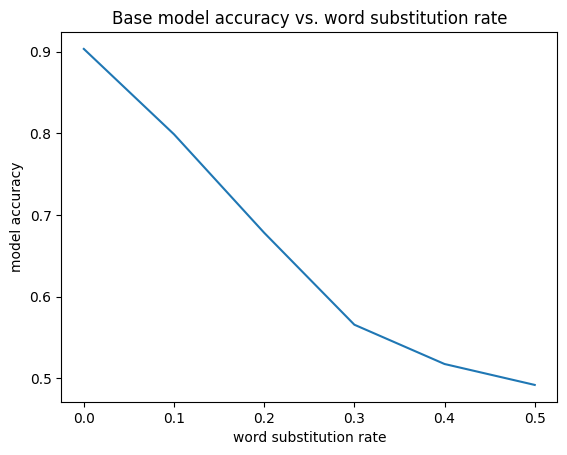

In [11]:
plt.plot(pcts, accuracies)
plt.title("Base model accuracy vs. word substitution rate")
plt.xlabel('word substitution rate')
plt.ylabel('model accuracy')

In [12]:
X_aug = pd.Series(list(map(clean_text, get_augmented(0.4))))



In [13]:
nlp_aug = spacy.load("en_core_web_sm") 

config = { 
   "threshold": 0.5, 
   "model": DEFAULT_MULTI_TEXTCAT_MODEL 
} 

textcat_aug = nlp_aug.add_pipe("textcat", config=config) 
aug_train_examples = []
for idx, text in enumerate(X_aug[ix_train]):
    label = {"spam": bool(y_train[idx]), "ham": (not bool(y_train[idx]))} 
    aug_train_examples.append(Example.from_dict(nlp.make_doc(str(text)), {"cats": label}))

for idx, text in enumerate(X_train):
    label = {"spam": bool(y_train[idx]), "ham": (not bool(y_train[idx]))} 
    aug_train_examples.append(Example.from_dict(nlp.make_doc(str(text)), {"cats": label}))

textcat_aug.add_label("spam")
textcat_aug.add_label("ham")
textcat_aug.initialize(lambda: aug_train_examples, nlp=nlp_aug)



In [ ]:
epochs = 4
with nlp_aug.select_pipes(enable="textcat"): 
  optimizer = nlp_aug.resume_training() 
  for i in range(epochs):
    print(f"epoch {i} of {epochs}")
    random.shuffle(aug_train_examples) 
    for example in aug_train_examples: 
      nlp_aug.update([example], sgd=optimizer) 

epoch 0 of 4


In [ ]:
pct = 0.1

get_aug_error(pct, model=nlp_aug, name="wordnet_augmented_40pct")

In [ ]:
get_aug_error(0, model=nlp_aug, name="wordnet_augmented_40pct")

In [ ]:
# Running this cell reloads utils.py
# It is useful for debugging but otherwise has no effect
import utils
import importlib
importlib.reload(utils)
from utils import *